## Preparando dados de porcos e gatos

In [0]:
!pip install -q keras
!pip install -q tqdm
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [71]:
!sudo apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate


In [0]:
from google.colab import auth
auth.authenticate_user()

In [73]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
vcode = getpass.getpass()

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Cannot retrieve auth tokens.
Failure("Unexpected error response: {\n  \"error\": \"invalid_grant\",\n  \"error_description\": \"Bad Request\"\n}")
··········


In [74]:
!ls

original-images  test  train


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!mkdir "drive/My Drive/Porco"

In [0]:
from os import chdir

In [0]:
chdir("drive/My Drive/Porco/")

In [0]:
!ls

In [0]:
from IPython.display import Image

--2019-12-23 01:19:16--  https://cdn.mos.cms.futurecdn.net/j86BVMguzBFy5fY2wtpngP.jpg
Resolving cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)... 8.252.218.252, 8.240.93.124, 8.240.91.252
Connecting to cdn.mos.cms.futurecdn.net (cdn.mos.cms.futurecdn.net)|8.252.218.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424948 (415K) [image/jpeg]
Saving to: ‘j86BVMguzBFy5fY2wtpngP.jpg’

j86BVMguzBFy5fY2wtp 100%[===================>] 414.99K  --.-KB/s    in 0.03s   

2019-12-23 01:19:16 (11.7 MB/s) - ‘j86BVMguzBFy5fY2wtpngP.jpg’ saved [424948/424948]



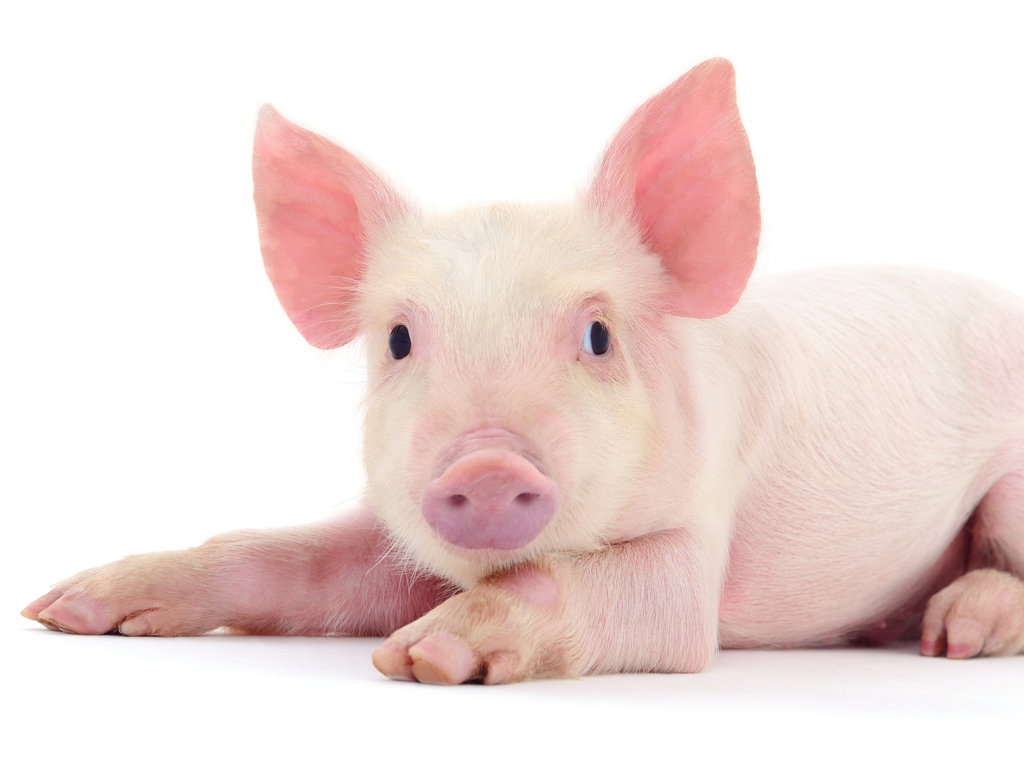

In [77]:
!wget https://cdn.mos.cms.futurecdn.net/j86BVMguzBFy5fY2wtpngP.jpg
Image("j86BVMguzBFy5fY2wtpngP.jpg")

In [17]:
!pip install google_images_download

     |████████████████████████████████| 911kB 4.8MB/s 
  Created wheel for google-images-download: filename=google_images_download-2.8.0-py2.py3-none-any.whl size=14550 sha256=da3cfe96107efd0d559ed3e87287362836a69fdf4cf5b059293d69ea740a5705
  Stored in directory: /root/.cache/pip/wheels/1f/28/ad/f56e7061e1d2a9a1affe2f9c649c2570cb9198dd24ede0bbab
Successfully built google-images-download


In [0]:
from google_images_download import google_images_download
response = google_images_download.googleimagesdownload()

In [0]:
arguments = {"keywords":"porco,cat","limit":60,"print_urls":False}
paths = response.download(arguments)
print(paths)

In [0]:
!mv downloads original-images

In [0]:
!mkdir test train

In [0]:
!rm -rf downloads 
arguments = {"keywords":"pig,cat","limit":60,"print_urls":False}
paths = response.download(arguments)
print(paths)

In [0]:
!ls test/cat/

In [0]:
arguments = {"keywords":"porcos,gato","limit":60,"print_urls":False}
paths = response.download(arguments)
print(paths)

In [0]:
!mv downloads train

In [0]:
!cd train && mv gato cat

In [62]:
!ls

original-images  test  train


---

## Importando bibliotecas e frameworks

In [0]:
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle
from PIL import Image, ImageChops, ImageOps
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense

In [0]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense


## Criando Modelo

In [0]:
clf = Sequential()
clf.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation="relu"))
clf.add(MaxPooling2D(pool_size = (2, 2)))
clf.add(Conv2D(32, (3, 3), activation = 'relu'))
clf.add(MaxPooling2D(pool_size = (2, 2)))
clf.add(Flatten())
clf.add(Dense(activation="relu", units=128))
clf.add(Dense(activation="sigmoid", units=1))
clf.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [0]:
chdir("/content/drive/My Drive/images/")

In [81]:
!ls

j86BVMguzBFy5fY2wtpngP.jpg  original-images  test  train


## Definindo treino e teste

In [91]:
from keras.preprocessing.image import ImageDataGenerator

traino_data_gen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
test_dataset = ImageDataGenerator(rescale = 1./255)
treino_dataset = traino_data_gen.flow_from_directory('./train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_data = test_dataset.flow_from_directory('./test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')



Found 116 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


## Treinando modelo

In [96]:
clf.fit_generator(treino_dataset,
                         steps_per_epoch = (130),
                         epochs = 3,
                         validation_data = test_data,
                         validation_steps = 100)

Epoch 1/3
  4/130 [..............................] - ETA: 1:52 - loss: 0.2917 - acc: 0.8984

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:914: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


130/130 [==============================] - 165s 1s/step - loss: 0.1351 - acc: 0.9561 - val_loss: 1.2214 - val_acc: 0.7417
Epoch 2/3
130/130 [==============================] - 163s 1s/step - loss: 0.0343 - acc: 0.9912 - val_loss: 1.3061 - val_acc: 0.7333
Epoch 3/3
130/130 [==============================] - 163s 1s/step - loss: 0.0100 - acc: 0.9990 - val_loss: 1.6522 - val_acc: 0.7417


In [85]:
!ls

j86BVMguzBFy5fY2wtpngP.jpg  original-images  test  train


In [98]:

from IPython.display import Image
Image("j86BVMguzBFy5fY2wtpngP.jpg")

import numpy as np
from keras.preprocessing import image
test_ibage = image.load_img("j86BVMguzBFy5fY2wtpngP.jpg", target_size = (64, 64))
test_ibage = image.img_to_array(test_ibage)
test_ibage = np.expand_dims(test_ibage, axis = 0)
result = clf.predict(test_ibage)
print(result)
if result[0][0] == 1:
    prediction = 'cat'
else:
    prediction = 'pig'
    
print(result)
print(prediction)

[[0.]]
[[0.]]
pig
